In [1]:
import pandas as pd
import numpy as np
import os.path
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('bagofwords.csv')
df.head()


,webpageID,labels,ac,add,advantage,anzeigen,apply,atom,au,auf,...,votre,vous,vpro,werden,windows,wireless,xeon,xps,zu,zur
0,000004_,desktops,0,0,5,0,7,2,0,0,...,0,0,4,0,9,0,5,17,0,0
1,000006_,laptops,0,0,5,0,7,2,0,0,...,0,0,2,0,6,0,4,23,0,0
2,000007_,enterprise-products,0,0,5,0,1,2,0,0,...,0,0,2,0,0,0,4,0,0,0
3,000009_,laptops,0,0,5,0,7,2,0,0,...,0,0,2,0,6,0,4,23,0,0
4,000011_,laptops,0,0,5,0,7,2,0,0,...,0,0,2,0,6,0,4,23,0,0


In [3]:
X_train=df.iloc[:,2:]
labels=df.loc[:,'labels'].values
le=LabelEncoder()
y_train=le.fit_transform(labels)
dictlabels=dict(zip(y_train,labels))
print(dictlabels)
print(X_train.shape)

{0: 'all-products', 1: 'cloud-client-computing', 2: 'deals', 3: 'dell-tablets', 4: 'desktops', 5: 'document_', 6: 'enterprise-products', 7: 'laptops', 8: 'other-product', 9: 'server-storage-solutions', 10: 'software', 11: 'unkowntype_'}
(5000, 200)


In [4]:
scores=[]
scores_std=[]
N_trees=[5,10,20,30,40,50,100,150,200]
for n_tree in N_trees:
    randomforest=RandomForestClassifier(n_estimators=n_tree,n_jobs=-1)
    score=cross_val_score(estimator=randomforest,X=X_train,y=y_train,cv=10,n_jobs=-1)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))

[ 0.96196478  0.97393812  0.97893848  0.97894194  0.98174172  0.982157
  0.98354903  0.98315742  0.98335624]


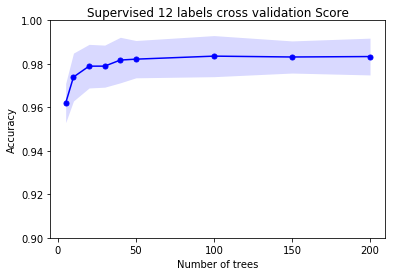

In [5]:
scores=np.array(scores)
print(scores)
scores_std=np.array(scores_std)
plt.plot(N_trees,scores,color='blue',marker='o',markersize='5')
plt.fill_between(N_trees,scores+scores_std,scores-scores_std,alpha=0.15,color='blue')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.ylim([0.9,1.0])
plt.title('Supervised 12 labels cross validation Score')
plt.show()


In [6]:
randomforest.fit(X_train,y_train)
importances = randomforest.feature_importances_
indices=np.argsort(importances)[::-1]

words_count=np.sum(X_train,axis=0)

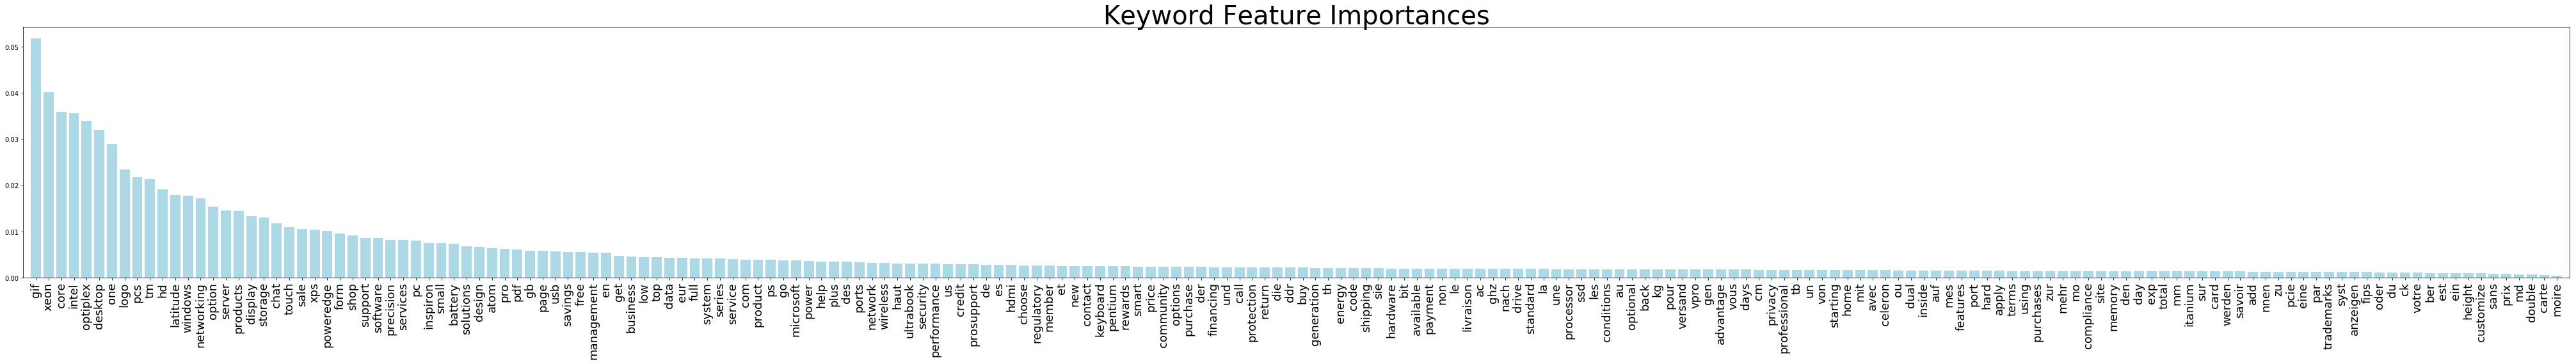

In [7]:
fig=plt.figure(figsize=(56,8))
tmp=200
plt.title('Keyword Feature Importances', fontsize = 40)
plt.bar(range(len(df.columns[2:][:tmp])),importances[indices][:tmp],color='lightblue',align='center')
plt.xticks(range(len(df.columns[2:][:tmp])),np.array(df.columns[2:])[indices][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()


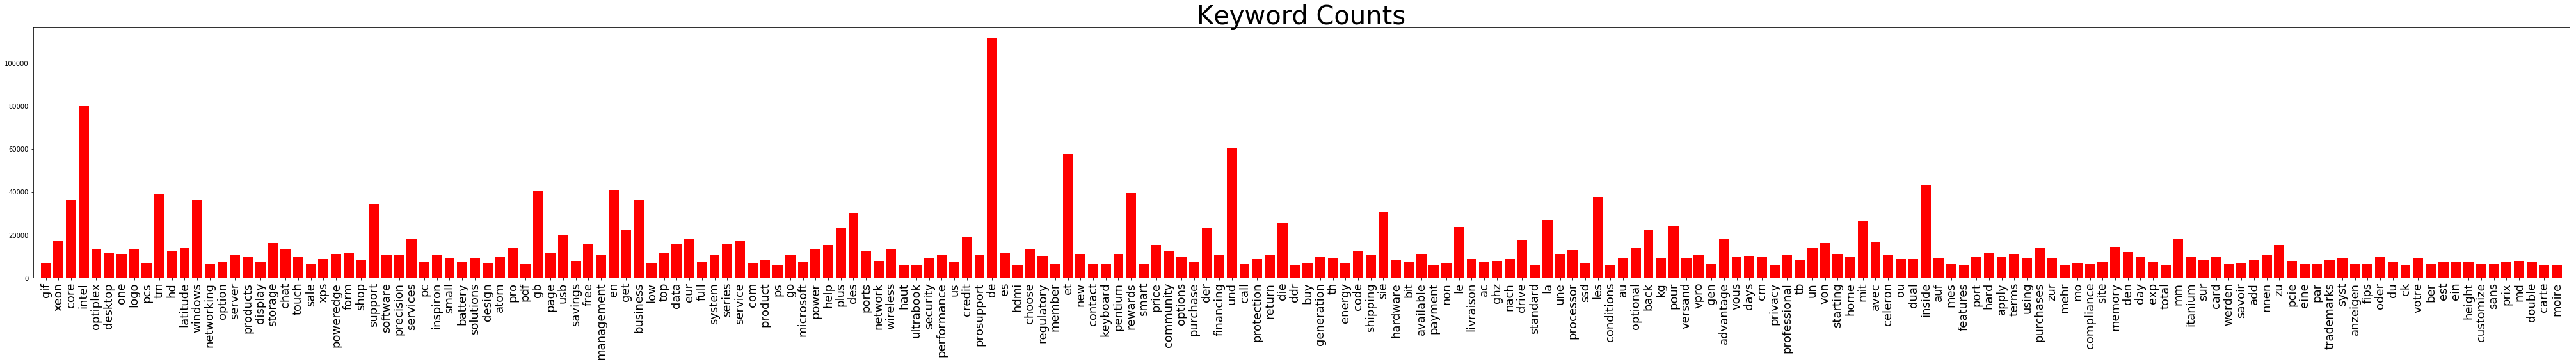

In [8]:
fig=plt.figure(figsize=(56,8))
plt.title('Keyword Counts', fontsize = 40)
plt.bar(range(len(df.columns[2:][:tmp])),words_count[indices][:tmp],color='red',align='center')
plt.xticks(range(len(df.columns[2:][:tmp])),np.array(df.columns[2:])[indices][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()


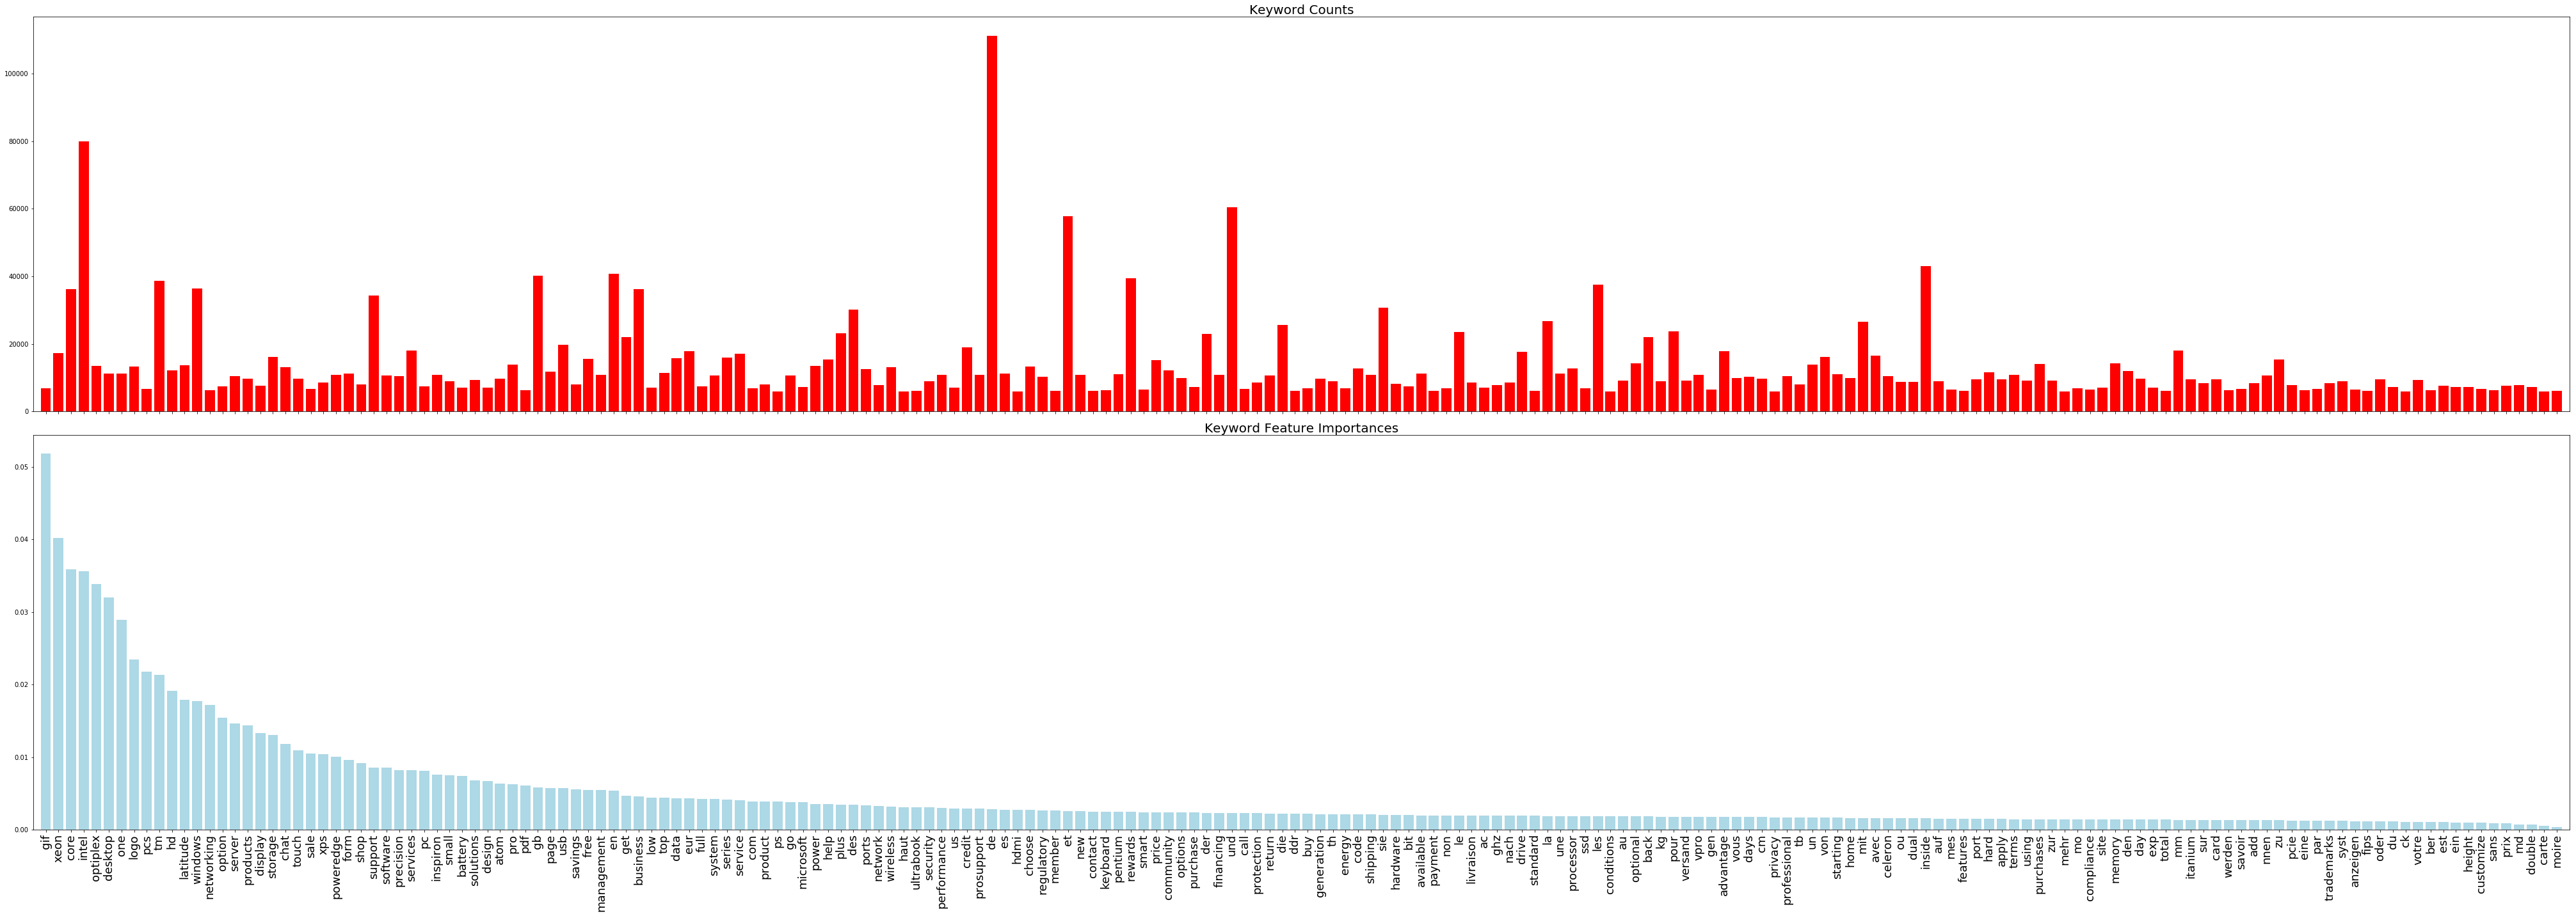

In [9]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(56,20),sharex=True)
ax[1].bar(range(len(df.columns[2:][:tmp])),importances[indices][:tmp],color='lightblue',align='center')
ax[1].set_title('Keyword Feature Importances', fontsize=20)
ax[0].set_title('Keyword Counts',fontsize=20)
ax[0].bar(range(len(df.columns[2:][:tmp])),words_count[indices][:tmp],color='red',align='center')
plt.xticks(range(len(df.columns[2:][:tmp])),np.array(df.columns[2:])[indices][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()